In [59]:
import signal
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import toolz as tz
from multiprocessing import Pool
from time import sleep

random = np.random.default_rng()

class TimeoutException(Exception):
    pass
def timeout_handler(signum, frame):
    raise TimeoutException

def is_predecessor(a,b):
    "returns the overlap amount if a is a predecessor of b; -1 otherwise"
    for i in range(len(a)):
        if b.startswith(a[i:]):
            return len(a)-i
    return -1

@tz.curry
def single_node_overlap_graph(focus_kmer,other_kmers,min_overlap=5):
    G = nx.DiGraph()
    for k in other_kmers:
        if focus_kmer!=k and (overlap:=is_predecessor(focus_kmer,k)) >= min_overlap:
            G.add_edge(focus_kmer,k,overlap=overlap)
    return G

def find_first_possible_pair(graph,):
    "return the first pair of nodes ini->end that are connected"
    inout = pd.DataFrame({"in_":dict(graph.in_degree()),"out":dict(graph.out_degree())})
    inout = inout.sample(frac=1)
    ini_nodes = inout.query("(in_==0)&(out!=0)")
    end_nodes = inout.query("(in_!=0)&(out==0)")
    if ini_nodes.empty or end_nodes.empty:
        raise ValueError("There are no initial or final nodes; try increasing the minimum overlap in your graph")
    for ini in ini_nodes.index:
        for end in end_nodes.index:
            if nx.has_path(graph,ini,end):
                #print(ini,end)
                return (ini,end)
    raise ValueError("Cannot reach any final nodes from any of the initial nodes")

def approximate_longest_simple_path(graph,weight="overlap",check_first_n=200):
    "return the longest path and its weight"
    pair = find_first_possible_pair(graph)
    paths = []
    if pair is not None:
        path_generator = nx.all_simple_paths(graph,*pair)
        for i,path in enumerate(path_generator):
            paths.append(path)
            if i >= check_first_n:
                break
        path_overlaps = [nx.path_weight(graph,path,"overlap") for path in paths]
        return paths[np.argmax(path_overlaps)],np.max(path_overlaps)
    else:
        return [],0

In [161]:
kmers = Path("kmers_10000.txt").read_text().split()
min_overlap = 5

In [162]:
with Pool(processes=8) as p:
    graphs = list(tqdm(
        p.imap(single_node_overlap_graph(other_kmers=kmers,min_overlap=min_overlap),kmers),
        total=len(kmers)
    ))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [165]:
graphs = [*filter(bool,graphs)]

In [166]:
%time G_old = nx.compose_all(graphs)

CPU times: user 881 ms, sys: 6.42 ms, total: 887 ms
Wall time: 888 ms


In [167]:
len(G_old.edges),len(G_old.nodes)

(170321, 10000)

In [173]:
@tz.curry
def find_longest_independent_paths(graph,timeout=10,check_first_n=3):
    G = graph.copy()
    paths = []
    total_overlaps = []
    
    signal.signal(signal.SIGALRM, timeout_handler)
    
    for i in tqdm(range(30)):
        signal.alarm(10) # limit execution of each iteration to this number of seconds
        try:
            path,overlap = approximate_longest_simple_path(G,weight="overlap",check_first_n=3)
            if len(path) > 5:
                paths.append(path)
                total_overlaps.append(overlap)
                G.remove_nodes_from(path)
        except TimeoutException:
            print("Timed out!")
            continue
        else:
            signal.alarm(0)
        finally:
            signal.alarm(0)
    path_properties = pd.DataFrame({
        "total overlap":total_overlaps,
        "path length":[len(p) for p in paths]
    }).sort_values(["total overlap","path length"],ascending=False)
    return paths,path_properties

In [193]:
np.zeros((100,4))[0]

array([0., 0., 0., 0.])

In [194]:
N = 100
path_legths_upto_4 = np.zeros((N,4))

for i in tqdm(range(N)):
    paths,path_properties = find_longest_independent_paths(G_old)
    path_legths_upto_4[i] = path_properties.iloc[:4]["path length"]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Timed out!
Timed out!
Timed out!


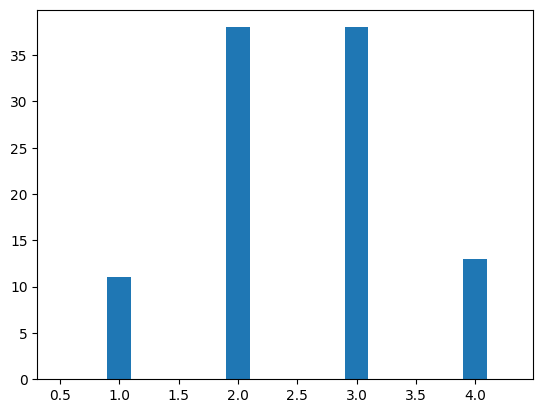

In [219]:
plt.hist(np.sum(path_legths_upto_4 > 200,axis=1),np.arange(0.5,4.5,0.2));

In [220]:
tmp = path_legths_upto_4.copy()
tmp[tmp<200] = np.nan

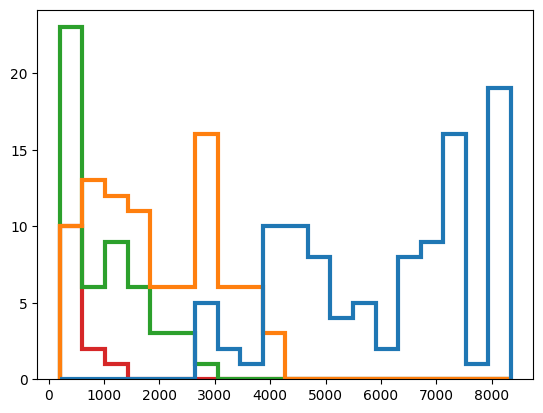

In [231]:
plt.hist(tmp,20,histtype="step",linewidth=3);

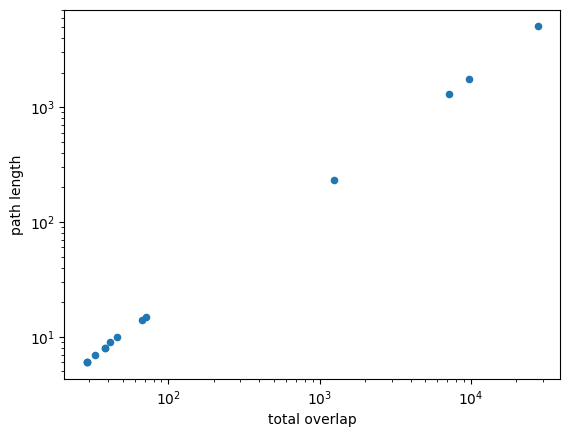

In [181]:
path_properties.plot(kind="scatter",x="total overlap",y="path length")
plt.xscale("log")
plt.yscale("log")

In [183]:
paths[path_properties.index[0]]

['GAGTGTTTCTAAAATT',
 'TAAAATTAAGTGCCCT',
 'GCCCTGGGCGGCTTCG',
 'GCTTCGCTGAGACAGAG',
 'ACAGAGGTGGAAGTGC',
 'AGTGCTTTTTTGTTA',
 'TGTTAGCGTGGGAAACG',
 'AAACGCTAAAAATAGTT',
 'ATAGTTAATCATATTA',
 'ATATTAAATACAAGTA',
 'ACAAGTATATTATCCTC',
 'ATCCTCATTTGCTTTTA',
 'TTTTATAATTTTATA',
 'TTTATAGTATACTTTAA',
 'CTTTAAATAAATACCTT',
 'TACCTTATGAACTAT',
 'ACTATAACTATATCATA',
 'TCATAAGTATCACTAAT',
 'TCACTAATCAAGTGAT',
 'GTGATGCAAAGGTTGA',
 'GGTTGAAGAACGCTTG',
 'GCTTGCTTTTAACGTAC',
 'CGTACCACATGGTCGAT',
 'TCGATAGCTGCAGGC',
 'CTGCAGGCCGCAGTCCT',
 'GTCCTCCCGGAGGCGGA',
 'GCGGAAGTCGATCTC',
 'ATCTCTTCCATCTTTT',
 'CTTTTGAAAACATATT',
 'ACATATTAGGTAGGGC',
 'AGGGCCTCGGCGTGGCG',
 'TGGCGCTGCGGGTGCCG',
 'GGTGCCGCGCATCCGA',
 'TCCGATGGGGGCTACG',
 'CTACGACGATGCCAACA',
 'CAACAGGCACACCTTC',
 'CCTTCGCCGGCTGCGA',
 'TGCGAGGCCGCCATGAA',
 'ATGAAAAGTATTACT',
 'TTACTTCTAATAAGTA',
 'ATAAGTATAGAAAAT',
 'AAAATCTTGCCGTTCT',
 'TGCCGTTCTATGCCTAT',
 'CCTATGAAGCGGCCA',
 'CGGCCAGGCGGTCCG',
 'GTCCGGGTCCACCGT',
 'ACCGTGCAGCCCTGCCC',
 'CT